In [1]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [21]:
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()


In [22]:
# Normalize 
train_images, test_images = train_images / 255.0, test_images / 255.0
train_images,valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)


# Replicate into three channels
train_images = tf.image.grayscale_to_rgb(tf.expand_dims(train_images, axis=-1))
test_images = tf.image.grayscale_to_rgb(tf.expand_dims(test_images, axis=-1))
valid_images = tf.image.grayscale_to_rgb(tf.expand_dims(valid_images, axis=-1))
# One-hot encode labels
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)
valid_labels = to_categorical(valid_labels, 10)

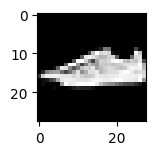

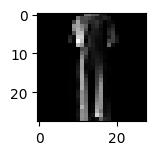

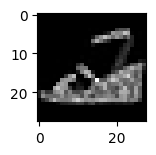

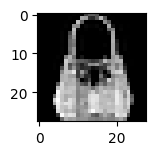

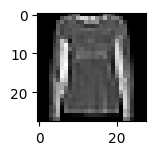

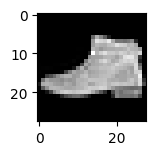

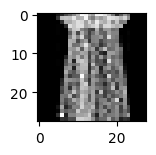

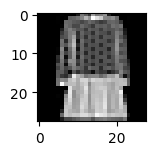

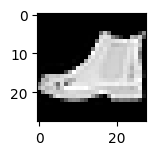

In [9]:
import matplotlib.pyplot as plt
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(valid_images[i], cmap='gray')
    plt.show()

In [14]:
def inception_module(filters,x):
    conv11=tf.keras.layers.Conv2D(filters=filters[0],kernel_size=1,padding='same',activation='relu')(x)
    conv33r=tf.keras.layers.Conv2D(filters=filters[1],kernel_size=1,padding='same',activation='relu')(x)
    conv33=tf.keras.layers.Conv2D(filters=filters[2],kernel_size=3,padding='same',activation='relu')(conv33r)
    conv55r=tf.keras.layers.Conv2D(filters=filters[3],kernel_size=1,padding='same',activation='relu')(x)
    conv55=tf.keras.layers.Conv2D(filters=filters[4],kernel_size=5,padding='same',activation='relu')(conv55r)
    mp=tf.keras.layers.MaxPool2D(pool_size=3,strides=1,padding='same')(x)
    poolproj=tf.keras.layers.Conv2D(filters=filters[5],kernel_size=1,padding='same',activation='relu')(mp)
    concat=tf.keras.layers.concatenate([conv11,conv33,conv55,poolproj],axis=-1)
    return concat


In [15]:
def aux_classifier(x,classes):
    avg_pooling=tf.keras.layers.AveragePooling2D(pool_size=5,strides=3,padding='same')(x)
    conv1=tf.keras.layers.Conv2D(filters=128,kernel_size=1,strides=1,activation='relu',padding='same')(avg_pooling)
    FC=tf.keras.layers.Flatten()(conv1)
    FC=tf.keras.layers.Dense(units=1024,activation='relu')(FC)
    x=tf.keras.layers.Dropout(0.7)(FC)
    x=tf.keras.layers.Dense(units=classes,activation='softmax')(x)
    return x



In [16]:
def GoogleNet(input_shape,classes):
    input_layer=tf.keras.layers.Input(shape=input_shape)

    x=tf.keras.layers.Conv2D(filters=64,strides=2,kernel_size=7,padding='same',activation='relu')(input_layer)
    x=tf.keras.layers.MaxPool2D(pool_size=3,strides=2,padding='same')(x)
    x=tf.keras.layers.Lambda(lambda z:tf.nn.local_response_normalization(z))(x)

    x=tf.keras.layers.Conv2D(filters=64,kernel_size=1,strides=1,padding='same',activation='relu')(x)
    x=tf.keras.layers.Conv2D(filters=192,kernel_size=3,strides=1,activation='relu',padding='same')(x)
    x=tf.keras.layers.Lambda(lambda z:tf.nn.local_response_normalization(z))(x)
    x=tf.keras.layers.MaxPool2D(pool_size=3,strides=2,padding='same')(x)





    filter_a3=[64,96,128,16,32,32]
    x=inception_module(filter_a3,x)
    filter_b3=[128,128,192,32,96,64]
    x=inception_module(filter_b3,x)
    x=tf.keras.layers.MaxPool2D(pool_size=3,strides=2,padding='same')(x)

    filter_a4=[192,96,208,16,48,64]
    x=inception_module(filter_a4,x)
    aux1=aux_classifier(x,classes)
    filter_b4=[160,112,224,24,64,64]
    x=inception_module(filter_b4,x)


    filter_c4=[128,128,256,24,64,64]
    x=inception_module(filter_c4,x)

    filter_d4=[112,144,288,32,64,64]
    x=inception_module(filter_d4,x)

    aux2=aux_classifier(x,classes)
    filter_e4=[256,160,320,32,128,128]
    x=inception_module(filter_e4,x)


    x=tf.keras.layers.MaxPool2D(pool_size=3,strides=2,padding='same')(x)

    filter_a5=[256,160,320,32,128,128]
    x=inception_module(filter_a5,x)

    filter_b5=[384,192,384,48,128,128]
    x=inception_module(filter_b5,x)
    x=tf.keras.layers.GlobalAveragePooling2D()(x)
    x=tf.keras.layers.Dropout(0.4)(x)

    output=tf.keras.layers.Dense(classes,activation='softmax')(x)

    model=Model(inputs=input_layer,outputs=[output,aux1,aux2])
    return model






In [23]:
model = GoogleNet(input_shape=(28, 28, 3), classes=10)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history=model.fit(train_images, train_labels, batch_size=64, epochs=10, validation_data=(valid_images, valid_labels))

# Evaluate the model
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])



Epoch 1/10
 71/750 [=>............................] - ETA: 3:02 - loss: 5.8617 - dense_9_loss: 1.9644 - dense_6_loss: 1.9012 - dense_8_loss: 1.9961 - dense_9_accuracy: 0.2223 - dense_6_accuracy: 0.2366 - dense_8_accuracy: 0.1998

KeyboardInterrupt: 

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')

KeyError: 'accuracy'

In [19]:
score

[1.1834818124771118,
 0.40588220953941345,
 0.37901246547698975,
 0.39858701825141907,
 0.8723000288009644,
 0.878000020980835,
 0.8759999871253967]

In [26]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_139 (Conv2D)         (None, 16, 16, 64)           9472      ['input_4[0][0]']             
                                                                                                  
 max_pooling2d_32 (MaxPooli  (None, 8, 8, 64)             0         ['conv2d_139[0][0]']          
 ng2D)                                                                                            
                                                                                                  
 lambda_6 (Lambda)           (None, 8, 8, 64)             0         ['max_pooling2d_32[0][0]

In [31]:
#plot the accuracy
import matplotlib.pyplot as plt
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


KeyError: 'accuracy'

In [32]:
print(history.keys())

dict_keys([])
